In [11]:
# imports
import astropy
import numpy as np
from astropy.io import fits, votable
from astropy.table import Table, Column
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
from glob import glob
from statistics import median, mean
from scipy.stats.mstats import theilslopes
from IPython.core.debugger import set_trace
import time
import cProfile

In [12]:
def LinFitData(fin):
    # list of match_id's 
    start = time.clock()
    #cols = fin.colnames
    fin = fin.group_by('MATCH_ID')
    col = Column([0]*len(fin), name='OUT_FLAG')
    fin.add_column(col)
    keys = fin.groups.keys[0:1000]
    #t = np.array([], dtype=tb.Row)
    # Remove flagged observations
    out2 = [i for i,j in enumerate(fin) if fin['IMAFLAGS_ISO'][i] != 0]
    fin['OUT_FLAG'][out2] = 1
    # remove COADD from values
    out1 = [i for i,j in enumerate(fin) if fin['VERSION'][i] == 'COADD']
    fin['OUT_FLAG'][out1] = 2
    for match_id in keys['MATCH_ID']:
        pec = np.where(fin['MATCH_ID'] == match_id)
        pec2 = np.where(fin[pec]['OUT_FLAG'] == 0)
        pec3 = fin[pec2]
        #pec3 = [i for i in pec['OUT_FLAG'][i] == 0]
        # minimum number of observation needed for fit - 3,4?
        if len(pec3['MJD_OBS']) < 4:
            continue
        else:
            # RA over time
            ts2 = theilslopes(pec3['NEW_RA'], pec3['MJD_OBS'])
            # Dec over time
            ts3 = theilslopes(pec3['NEW_DEC'], pec3['MJD_OBS'])
            least_dist_ra = []
            least_dist_dec = []
            # calculate absolute distance from each obs to fit line
            for iden in pec3:
                d = np.abs(ts2[1] + ts2[0]*iden['MJD_OBS'] - iden['NEW_RA'])/np.sqrt(1 + ts2[0]**2)
                least_dist_ra.append(d)
                d2 = np.abs(ts3[1] + ts3[0]*iden['MJD_OBS'] - iden['NEW_DEC'])/np.sqrt(1 + ts3[0]**2)
                least_dist_dec.append(d)
            # reject outliers based on absolute distance from theil slope fit line 3 sigma
            least_dist_ra = sigma_clip(least_dist_ra, sigma = 3)
            least_dist_dec = sigma_clip(least_dist_dec, sigma = 3)
            idx = [i for i in range(len(pec3)) if least_dist_ra.mask[i] == True]
            idx2 = [i for i in range(len(pec3)) if least_dist_dec.mask[i] == True]
            # intersection of invalid obs in RA and Dec
            idx3 = list(set(idx).intersection(set(idx2)))
            pec3['OUT_FLAG'][idx3] = 1
            if len(np.where(pec3['OUT_FLAG'] == 0)) < 3:
                pec3['OUT_FLAG'][:] = 1
    print(time.clock() - start)
    return fin[np.where(fin['OUT_FLAG'] != 1)]

In [9]:
fin = Table.read('DES0135-0416_final.fits')

In [13]:
# add row + for loop
out = LinFitData(fin)

33.843723


In [19]:
t = Table.read('DES0135-0416_proper_n.fits')
t2 = Table.read('DES0135-0416_proper.fits')

In [20]:
fil = t[np.where(t['VEL'] > 0.1)]

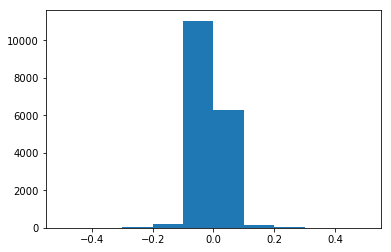

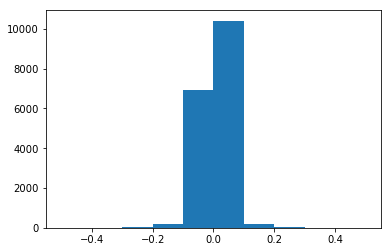

In [21]:
plt.hist(t['MU_RA'], range = (-0.5, 0.5))
plt.show()
plt.hist(t['MU_DEC'], range = (-0.5, 0.5))
plt.show()

MATCH_ID   COADD_ID    SPREAD_MODEL  ...      VEL         SIGMA_VEL   
-------- ----------- --------------- ... -------------- --------------
 20050.0 233010237.0 0.0151304006577 ... 0.262340572714 0.035882110836
MATCH_ID   COADD_ID    SPREAD_MODEL   ...      VEL          SIGMA_VEL   
-------- ----------- ---------------- ... -------------- ---------------
 20050.0 233025954.0 0.00870365276933 ... 0.172916742607  0.026185407092
 20050.0 233025960.0  0.0121062453836 ... 0.172916695928 0.0261854070961


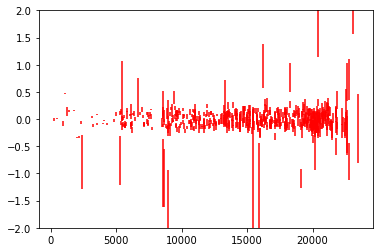

In [22]:
odd = []
for match_id in fil['MATCH_ID']:
    r1 = fil[np.where(fil['MATCH_ID'] == match_id)]
    r2 = t2[np.where(t2['MATCH_ID'] == match_id)]
    if match_id in t2['MATCH_ID']:
        if len(r1) != len(r2):
            print(r1)
            print(r2)
        plt.errorbar(match_id,r1[0]['MU_RA'] - r2[0]['MU_RA'],yerr = np.sqrt(r1[0]['MU_RA_ERR']) + np.sqrt(r2[0]['MU_RA_ERR']) ,c='r')
        if np.abs(r1[0]['MU_RA'] - r2[0]['MU_RA']) > 0.5:
            odd.append(match_id)
plt.ylim(-2, 2)
plt.show()

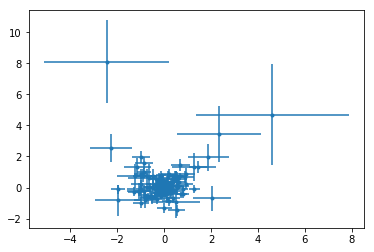

In [23]:
plt.errorbar(t['MU_RA'], t['MU_DEC'],xerr=np.sqrt(t['MU_RA_ERR']),yerr=np.sqrt(t['MU_DEC_ERR']),fmt= '.')
#plt.xlim(-0.25, 0.25)
#plt.ylim(-0.25, 0.25)
plt.show()

In [5]:
fin[np.where(fin['MATCH_ID'] == 26)]

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.464932,-3.927659,2.96232992696e-05,2017.53833008,3059.83618164,-0.0264941994101,0.00574863003567,866.835998535,173.901000977,232010,0,2.95163008559e-05,0.800786018372,-9999.0,0.498632997274,-9999.0,-88.4785995483,50.6468009949,-9999.0,9.33311983253e-10,14,g,56544.3527767,90.0,31.3410968781,y4a1_v1.5,-2.77423390818,1.04827676169,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,26.0,0.61,23.4649455635,-3.92768705187


In [9]:
t[0]['MU_RA'] 

-0.020617922652476757

In [20]:
# 513 with abs vs 482 with 3sigma
t

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478413,-3.915745,2.91511005344e-05,1765.3170166,3214.4855957,0.00550682004541,0.00538084004074,4603.02001953,759.780029297,370652,0,2.90657008009e-05,1.07752001286,-9999.0,0.831077992916,-9999.0,-50.2812004089,32.6792984009,-9999.0,2.02810997163e-11,14,i,56953.232467,90.0,31.1961688995,y4a1_v1.5,-2.76079209166,1.06026468929,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784356011,-3.9157616248
23.478442,-3.915774,1.54458994075e-05,1549.00012207,2631.30102539,0.0162247996777,0.00339853996411,4987.29980469,588.918029785,372595,0,1.5373199858e-05,1.53030002117,-9999.0,1.4470499754,-9999.0,-33.7636985779,-31.3174991608,-9999.0,6.30964031023e-11,12,r,56959.2592162,90.0,31.6641025543,y4a1_v1.5,-2.76074429493,1.06020892373,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784831566,-3.91581746345
23.478373,-3.915751,1.63110998983e-05,1514.23071289,2621.20385742,0.0112754004076,0.00373074994422,6820.75,902.994995117,379937,0,1.62625001394e-05,1.2553999424,-9999.0,1.14918994904,-9999.0,21.997800827,-29.9393005371,-9999.0,6.56333017449e-12,12,i,56982.1064331,90.0,31.6891498566,y4a1_v1.5,-2.76080592056,1.0602349838,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784216499,-3.91579123999
23.478436,-3.915771,1.90248993022e-05,289.773071289,2461.18066406,0.0144705995917,0.00442619016394,6124.04003906,854.236999512,600486,0,1.89628008229e-05,1.3665599823,-9999.0,0.992020010948,-9999.0,35.689201355,-14.7565002441,-9999.0,1.94596005976e-11,27,i,57729.0947371,90.0,31.6346721649,y4a1_v1.5,-2.76078779199,1.06025069469,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784398415,-3.91577561244
23.47842,-3.915788,2.32460006373e-05,1530.98864746,2626.32128906,0.00700344983488,0.00605168007314,5637.43017578,1064.54003906,398224,0,2.3192500521e-05,0.974309027195,-9999.0,0.751861989498,-9999.0,-60.198600769,-33.9263000488,-9999.0,4.92455989182e-12,12,z,57037.0415448,90.0,31.3256473541,y4a1_v1.5,-2.76074704692,1.06020981111,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784804087,-3.91581656837
23.478426,-3.915759,2.5118000849e-05,1848.02685547,3258.07592773,0.0166075006127,0.00632763002068,4925.81982422,1097.97998047,398228,0,2.50288994721e-05,1.86027002335,-9999.0,0.642650008202,-9999.0,-7.08715009689,21.9118995667,-9999.0,5.23652995965e-12,14,z,57037.0471445,90.0,31.3344364166,y4a1_v1.5,-2.76076661264,1.06023331376,1e+20,1

In [4]:
fin

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478404,-3.915761,3.88414009649e-05,1855.63549805,3244.83349609,0.00696353986859,0.00509651005268,1672.68005371,238.104003906,232010,0,3.87397994928e-05,1.32693994045,-9999.0,0.493640989065,-9999.0,-3.66163992882,31.235200882,-9999.0,6.40577979549e-10,14,g,56544.3527767,90.0,31.3410968781,y4a1_v1.5,-2.76069554821,1.06016292751,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4785317028,-3.91586355064
23.478411,-3.915749,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76081693177,1.06027700015,23.3447284698,22.5147724152,22.0132274628,21.9903831482,22.0709075928,233002738,23.4784108165,-3.91574925081,459.313171387,986.486206055,1565.70300293,1598.9934082,1484.69348145,0.125666484237,0.089109711349,0.100008971989,0.124492883682,0.436510413885,53.1494216919,80.9442901611,144.18447876,596.762573242,0.00665117893368,0.0022047040984,0.0,1.33150100708,23.4784108165,-3.91574925081
23.478413,-3.915745,2.91511005344e-05,1765.3170166,3214.4855957,0.00550682004541,0.00538084004074,4603.02001953,759.780029297,370652,0,2.90657008009e-05,1.07752001286,-9999.0,0.831077992916,-9999.0,-50.2812004089,32.6792984009,-9999.0,2.02810997163e-11,14,i,56953.232467,90.0,31.1961688995,y4a1_v1.5,-2.76079209166,1.06026468929,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784356011,-3.9157616248
23.478442,-3.915774,1.54458994075e-05,1549.00012207,2631.30102539,0.0162247996777,0.00339853996411,4987.29980469,588.918029785,372595,0,1.5373199858e-05,1.53030002117,-9999.0,1.4470499754,-9999.0,-33.7636985779,-31.3174991608,-9999.0,6.30964031023e-11,12,r,56959.2592162,90.0,31.6641025543,y4a1_v1.5,-2.76074429493,1.06020892373,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784831566,-3.91581746345
23.478373,-3.915751,1.63110998983e-05,1514.23071289,2621.20385742,0.0112754004076,0.00373074994422,6820.75,902.994995117,379937,0,1.62625001394e-05,1.2553999424,-9999.0,1.14918994904,-9999.0,21.997800827,-29.9393005371,-9999.0,6.56333017449e-12,12,i,56982.1064331,90.0,31.6891498566,y4a1_v1.5,-2.76080592056,1.0602349838,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784216499,-3.91579123999
23.478436,-3.915771,1.90248993022e-05,289.773071289,2461.18066406,0.0144705995917,0.00442619016394,6124.04003906,854.236999512,600486,0,1.89628008229e-05,1.3665599823,-9999.0,0.992020010948,-9999.0,35.689201355,-14.7565002441,-9999.0,1.94596005976e-11,27,i,57729.0947371,90.0,3

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,str5,float64,float64,float64,str30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.478404,-3.915761,3.88414009649e-05,1855.63549805,3244.83349609,0.00696353986859,0.00509651005268,1672.68005371,238.104003906,232010,0,3.87397994928e-05,1.32693994045,-9999.0,0.493640989065,-9999.0,-3.66163992882,31.235200882,-9999.0,6.40577979549e-10,14,g,56544.3527767,90.0,31.3410968781,y4a1_v1.5,-2.76069554821,1.06016292751,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4785317028,-3.91586355064
23.478411,-3.915749,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.76081693177,1.06027700015,23.3447284698,22.5147724152,22.0132274628,21.9903831482,22.0709075928,233002738,23.4784108165,-3.91574925081,459.313171387,986.486206055,1565.70300293,1598.9934082,1484.69348145,0.125666484237,0.089109711349,0.100008971989,0.124492883682,0.436510413885,53.1494216919,80.9442901611,144.18447876,596.762573242,0.00665117893368,0.0022047040984,0.0,1.33150100708,23.4784108165,-3.91574925081
23.478413,-3.915745,2.91511005344e-05,1765.3170166,3214.4855957,0.00550682004541,0.00538084004074,4603.02001953,759.780029297,370652,0,2.90657008009e-05,1.07752001286,-9999.0,0.831077992916,-9999.0,-50.2812004089,32.6792984009,-9999.0,2.02810997163e-11,14,i,56953.232467,90.0,31.1961688995,y4a1_v1.5,-2.76079209166,1.06026468929,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784356011,-3.9157616248
23.478442,-3.915774,1.54458994075e-05,1549.00012207,2631.30102539,0.0162247996777,0.00339853996411,4987.29980469,588.918029785,372595,0,1.5373199858e-05,1.53030002117,-9999.0,1.4470499754,-9999.0,-33.7636985779,-31.3174991608,-9999.0,6.30964031023e-11,12,r,56959.2592162,90.0,31.6641025543,y4a1_v1.5,-2.76074429493,1.06020892373,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784831566,-3.91581746345
23.478373,-3.915751,1.63110998983e-05,1514.23071289,2621.20385742,0.0112754004076,0.00373074994422,6820.75,902.994995117,379937,0,1.62625001394e-05,1.2553999424,-9999.0,1.14918994904,-9999.0,21.997800827,-29.9393005371,-9999.0,6.56333017449e-12,12,i,56982.1064331,90.0,31.6891498566,y4a1_v1.5,-2.76080592056,1.0602349838,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,0.0,1.33150100708,23.4784216499,-3.91579123999
23.478436,-3.915771,1.90248993022e-05,289.773071289,2461.18066406,0.0144705995917,0.00442619016394,6124.04003906,854.236999512,600486,0,1.89628008229e-05,1.3665599823,-9999.0,0.992020010948,-9999.0,35.689201355,-14.7565002441,-9999.0,1.94596005976e-11,27,i,57729.0947371,90.0,3

In [102]:
x= np.array(fin[0])
x.dtype

dtype([('RA', '>f8'), ('DEC', '>f8'), ('ERRAWIN_WORLD', '>f8'), ('XWIN_IMAGE', '>f8'), ('YWIN_IMAGE', '>f8'), ('SPREAD_MODEL', '>f8'), ('SPREADERR_MODEL', '>f8'), ('FLUX_AUTO', '>f8'), ('FLUXERR_AUTO', '>f8'), ('EXPNUM', '>i8'), ('IMAFLAGS_ISO', '>i4'), ('ERRBWIN_WORLD', '>f8'), ('A_IMAGE', '>f8'), ('ERRA_IMAGE', '>f8'), ('B_IMAGE', '>f8'), ('ERRB_IMAGE', '>f8'), ('THETA_IMAGE', '>f8'), ('ERRTHETAWIN_J2000', '>f8'), ('CHI2_MODEL', '>f8'), ('CHI2_PSF', '>f8'), ('CCDNUM', '>i2'), ('BAND', '<U5'), ('MJD_OBS', '>f8'), ('EXPTIME', '>f8'), ('MAG_ZERO', '>f8'), ('VERSION', '<U30'), ('X_GNOM', '>f8'), ('Y_GNOM', '>f8'), ('MAG_AUTO_G', '>f8'), ('MAG_AUTO_R', '>f8'), ('MAG_AUTO_I', '>f8'), ('MAG_AUTO_Z', '>f8'), ('MAG_AUTO_Y', '>f8'), ('COADD_OBJECT_ID', '>i8'), ('ALPHAWIN_J2000', '>f8'), ('DELTAWIN_J2000', '>f8'), ('FLUX_AUTO_G', '>f8'), ('FLUX_AUTO_R', '>f8'), ('FLUX_AUTO_I', '>f8'), ('FLUX_AUTO_Z', '>f8'), ('FLUX_AUTO_Y', '>f8'), ('MAGERR_AUTO_G', '>f8'), ('MAGERR_AUTO_R', '>f8'), ('MAGERR_AU